In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
from time import time
import itertools
from scipy import stats, signal

from neurodsp.filt import filter_signal
from neurodsp.timefrequency import freq_by_time
from neurodsp.sim import sim_filtered_noise, sim_bursty_oscillator
from bycycle.features import compute_features

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
sns.set_style('white')
plt.style.use('Cole_2018.mplstyle')

from config import config_sim

# Simulate trial data with 3 conditions

In [2]:
# Define general simulation parameters
N_trials = 100
Fs = config_sim['fs']
rdsym = .5
exponent = -2

tlims = (-1, 2)
T_full = tlims[1] - tlims[0]
T_burst = tlims[1]
t = np.arange(tlims[0], tlims[1], 1/Fs)

# Define simulation parameters
conditions = ['baseline', 'faster', 'more bursts']
colors = ['k', 'r', 'b']
osc_freqs = {'baseline': 10, 'more bursts': 10, 'faster': 11}
prob_leave_bursts = {'baseline': .1, 'more bursts': .1, 'faster': .1}
prob_enter_bursts = {'baseline': .1, 'more bursts': .2, 'faster': .1}
cycle_features = {'amp_std': .1,'period_std': 5, 'rdsym_std': .05}
osc_detect_kwargs = {'amplitude_fraction_threshold':0,
                     'amplitude_consistency_threshold':.6,
                     'period_consistency_threshold':.6,
                     'monotonicity_threshold':.9,
                     'N_cycles_min':3}

In [3]:
# For each condition
xs = defaultdict(list)
dfs = defaultdict(list)
np.random.seed(1)
start_time = time()
for c in conditions:
    for tr in range(N_trials):
        # Simulate noise
        brown = sim_filtered_noise(T_full + 10, Fs, exponent = exponent,
                                   f_range=config_sim['f_range_noise'],
                                   filter_order=config_sim['filter_order_noise'])
        brown = brown[:len(t)]
        brown = stats.zscore(brown)
        
        # Generate oscillator after time zero
        oscillator, df = sim_bursty_oscillator(T_burst, Fs, osc_freqs[c], 
                                               prob_enter_burst=prob_enter_bursts[c],
                                               prob_leave_burst=prob_leave_bursts[c],
                                               rdsym = rdsym,
                                               cycle_features=cycle_features,
                                               return_cycle_df=True)
        
        # Add oscillator after time zero
        x = np.copy(brown)
        x[-len(oscillator):] += 3*oscillator
        xs[c].append(x)
        dfs[c].append(df)
    print('Completed condition {:s}, # seconds = {:.0f}'.format(c, time() - start_time))

/Users/scott/anaconda/lib/python3.6/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]
/Users/scott/anaconda/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/scott/anaconda/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpre

Completed condition baseline, # seconds = 82
Completed condition faster, # seconds = 162
Completed condition more bursts, # seconds = 230


# A. Visualize single trials for each condition

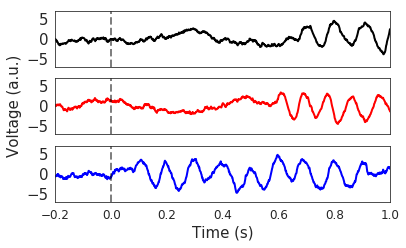

In [4]:
ymax = 7

trial_plot = {'baseline': 20, 'faster': 10, 'more bursts': 24}
plt.figure(figsize=(6,6))
for i, (k, color) in enumerate(zip(conditions, colors)):
    plt.subplot(5, 1, i+1)
    plt.plot(t, xs[k][trial_plot[k]], color=color)
    plt.plot([0,0], [-ymax, ymax], 'k--', alpha=.5)
    plt.xlim((-.2, 1))
    plt.ylim((-ymax,ymax))
    
    if i == len(conditions) - 1:
        plt.xticks(size=12)
    elif i == 1:
        plt.ylabel('Voltage (a.u.)', size=15)
        plt.xticks([])
    else:
        plt.xticks([])
plt.xlabel('Time (s)', size=15)

plt.savefig('figs/5A_condition_timeseries', bbox_inches='tight')

# B. Average event-related frequencies for simulated conditions

In [5]:
# Compute average event-related instantaneous frequency
freqs = defaultdict(list)
mean_freq_ts = defaultdict()
for c in conditions:
    for tr in range(N_trials):
        # Compute instantaneous frequency and median filter it as in Samaha 2015 Curr Bio
        i_f = freq_by_time(xs[c][tr], Fs, config_sim['f_range'],
                           filter_kwargs={'compute_transition_band': False},
                           remove_edge_artifacts=False)
        i_f2 = i_f.copy()
        for samps in np.linspace(11, 401, 10):
            samps = int(samps)
            if samps % 2 == 0:
                samps += 1
            i_f2 = signal.medfilt(i_f2, kernel_size=samps)

        freqs[c].append(i_f2)
    mean_freq_ts[c] = np.mean(np.array(freqs[c]), axis=0)

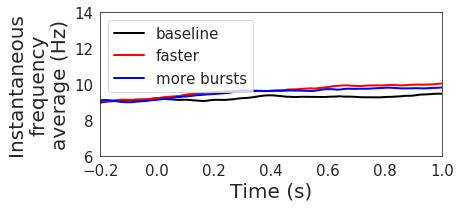

In [6]:
plt.figure(figsize=(6.5, 3))
for i, c in enumerate(conditions):
    plt.plot(t, mean_freq_ts[c], label=c, color=colors[i])

plt.xlim((-.2, 1))
plt.ylim((6, 14))
plt.legend(loc='best', fontsize=15)
plt.xlabel('Time (s)')
plt.ylabel('Instantaneous\nfrequency\naverage (Hz)')

plt.tight_layout()
plt.savefig('figs/5B_inst_freq_ts')

# Compute cycle by cycle features

In [7]:
# Define event-related bins
bin_edges = np.arange(-.5, 1.1, .1)
bin_centers = (bin_edges[1:] + bin_edges[:-1])/2

xs_filt = defaultdict(list)
binned_periods = defaultdict()
binned_freqs = defaultdict()
binned_bursts = defaultdict()
dfs_shape = defaultdict(list)
for c in conditions:
    for tr in range(N_trials):
        # Apply lowpass filter
        x_filt = filter_signal(xs[c][tr], Fs, 'lowpass', config_sim['lowpass_fc'],
                                n_seconds=config_sim['lowpass_n_seconds'],
                                compute_transition_band=False,
                                remove_edge_artifacts=False)
        xs_filt[c].append(x_filt)
        
        df_shape = compute_features(x_filt, Fs, config_sim['f_range'], center_extrema='P',
                                    burst_detection_kwargs=osc_detect_kwargs)
        df_shape['trial'] = tr
        dfs_shape[c].append(df_shape)
        
    # Aggregate all trials
    df_shape_cond = pd.concat(dfs_shape[c]).reset_index(drop=True)[['sample_peak', 'period', 'is_burst']]
    # Compute time from sample
    df_shape_cond['t'] = t[df_shape_cond['sample_peak'].values]
    # Bin time
    df_shape_cond['t_bin'] = pd.cut(df_shape_cond['t'], bin_edges)
    
    # Compute bursting and freq in each time bin
    df_burst_by_t = df_shape_cond.groupby('t_bin')['is_burst'].mean()
    df_period_by_t = df_shape_cond[df_shape_cond['is_burst']].groupby('t_bin')['period'].mean()
    binned_periods[c] = df_period_by_t.values
    binned_freqs[c] = 1000 / binned_periods[c]
    binned_bursts[c] = df_burst_by_t.values

/Users/scott/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/scott/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/scott/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/scott/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/scott/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/scott/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


# C. Average event-related cycle-by-cycle freqs

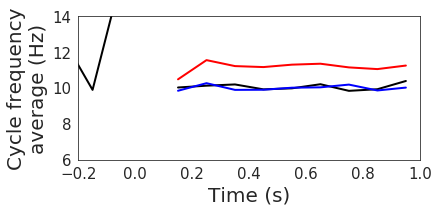

In [8]:
plt.figure(figsize=(6.2,3))
for i, c in enumerate(conditions):
    plt.plot(bin_centers, binned_freqs[c], label=c, color=colors[i])

plt.xlim((-.2, 1))
plt.ylim((6,14))
plt.xlabel('Time (s)')
plt.ylabel('Cycle frequency\naverage (Hz)')

plt.tight_layout()
plt.savefig('figs/5C_cycle_freq_ts')

# D. Average event-related bursting

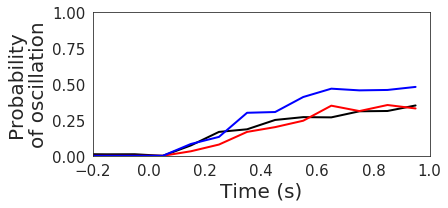

In [9]:
plt.figure(figsize=(6.2,3))
for i, c in enumerate(conditions):
    plt.plot(bin_centers, binned_bursts[c], label=c, color=colors[i])

plt.xlim((-.2, 1))
plt.ylim((0, 1))
plt.xlabel('Time (s)')
plt.ylabel('Probability\nof oscillation')

plt.tight_layout()
plt.savefig('figs/5D_cycle_burst_ts')

# Significance tests: instantaneous freq

In [17]:
# Compute mean instantaneous freq 500ms to 1000ms for each condition
tlim = (.5, 1)
tidxs = np.logical_and(t>=tlim[0], t<tlim[1])
inst_freq_trial_means = {}
for c in conditions:
    inst_freq_trial_means[c] = np.mean(np.array([x[tidxs] for x in freqs[c]]), axis=1)
    
# Test for differences between mean isntantaneous freqs
c1 = 'baseline'
for c2 in conditions[1:]:
    U, p = stats.mannwhitneyu(inst_freq_trial_means[c1], inst_freq_trial_means[c2])
    print('{:14s},  {:14s}: U={:3.0f}, p={:.6f}, p={:.0E}, mu1={:.2f}, mu2={:.2f}'.format(c1, c2, U, p, p,
                                                                                np.mean(inst_freq_trial_means[c1]),
                                                                                np.mean(inst_freq_trial_means[c2])))

baseline      ,  faster        : U=3278, p=0.000013, p=1E-05, mu1=9.32, mu2=9.90
baseline      ,  more bursts   : U=3302, p=0.000017, p=2E-05, mu1=9.32, mu2=9.74


# Significance tests: cycle freq

In [16]:
# Compute mean cycle freq 500ms to 1000ms for each condition
tlim = (.5, 1)
tidxs = np.logical_and(t>=tlim[0], t<tlim[1])
cycle_freq_trial_means = {}
for c in conditions:
    # Get dataframe of interest
    df_temp = pd.concat(dfs_shape[c])
    df_temp = df_temp[df_temp['is_burst']]
    df_temp['t'] = t[df_temp['sample_peak'].values]
    df_temp = df_temp[(df_temp['t']>=tlim[0]) & (df_temp['t']<tlim[1])]
    df_temp['freq'] = 1000 / df_temp['period']
    cycle_freq_trial_means[c] = df_temp.groupby('trial')['freq'].mean()
    
    
# Test for differences between mean isntantaneous freq
c1 = 'baseline'
for c2 in conditions[1:]:
    U, p = stats.mannwhitneyu(cycle_freq_trial_means[c1], cycle_freq_trial_means[c2])
    print('{:14s},  {:14s}: U={:3.0f}, p={:.6f}, p={:.0E}, mu1={:.2f}, mu2={:.2f}'.format(c1, c2, U, p, p,
                                                                                np.mean(cycle_freq_trial_means[c1]),
                                                                                np.mean(cycle_freq_trial_means[c2])))

baseline      ,  faster        : U= 62, p=0.000000, p=7E-13, mu1=10.21, mu2=11.29
baseline      ,  more bursts   : U=1254, p=0.500000, p=5E-01, mu1=10.21, mu2=10.09


# E. Distribution comparison (11Hz, baseline): instantaneous freq

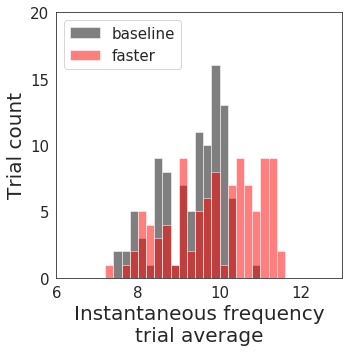

In [12]:
# Histogram of mean instantaneous freq to see trial differentiation
plt.figure(figsize=(5,5))
for i, c in enumerate(['baseline', 'faster']):
    plt.hist(inst_freq_trial_means[c], bins=np.arange(0, 15, .2), label=c, alpha=.5, color=colors[i])

plt.xlim((6, 13))
plt.ylim((0, 20))
plt.yticks(np.arange(0, 21, 5))
plt.legend(loc='best', fontsize=15)
plt.ylabel('Trial count')
plt.xlabel('Instantaneous frequency\ntrial average')

plt.tight_layout()
plt.savefig('figs/5E_inst_freq_dist')

# F. Distribution comparison (11Hz, baseline): cycle freq

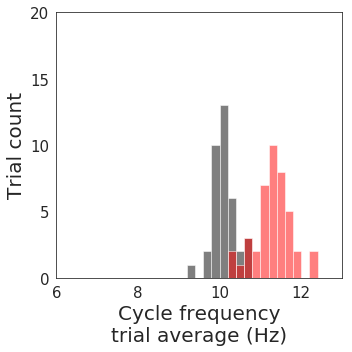

In [13]:
# Histogram of mean cycle freq to see trial differentiation
plt.figure(figsize=(5,5))
for i, c in enumerate(['baseline', 'faster']):
    plt.hist(cycle_freq_trial_means[c], bins=np.arange(0, 15, .2), label=c, alpha=.5, color=colors[i])

plt.xlim((6, 13))
plt.ylim((0, 20))
plt.yticks(np.arange(0, 21, 5))
plt.ylabel('Trial count')
plt.xlabel('Cycle frequency\ntrial average (Hz)')

plt.tight_layout()
plt.savefig('figs/5F_cycle_freq_dist')

# G. Distribution comparison (more bursting, baseline): instantaneous freq

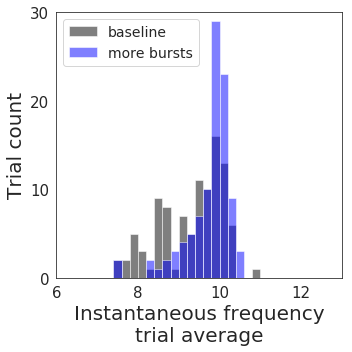

In [14]:
# Histogram of mean instantaneous freq to see trial differentiation
plt.figure(figsize=(5,5))
colors = ['k', 'b']
for c, color in zip(['baseline', 'more bursts'], ['k', 'b']):
    plt.hist(inst_freq_trial_means[c], bins=np.arange(0, 15, .2), label=c, alpha=.5, color=color)

plt.xlim((6, 13))
plt.ylim((0, 30))
plt.yticks(np.arange(0, 31, 10))
plt.legend(loc='best', fontsize=14)
plt.ylabel('Trial count')
plt.xlabel('Instantaneous frequency\ntrial average')

plt.tight_layout()
plt.savefig('figs/5G_inst_freq_dist')

# H. Distribution comparison (more bursting, baseline): cycle freq

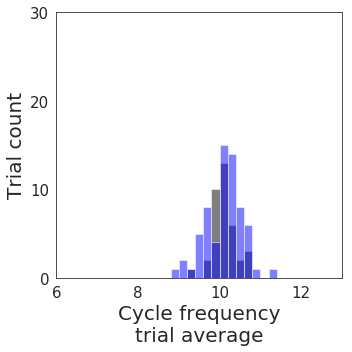

In [15]:
# Histogram of mean cycle freq to see trial differentiation
plt.figure(figsize=(5,5))
for c, color in zip(['baseline', 'more bursts'], ['k', 'b']):
    plt.hist(cycle_freq_trial_means[c], bins=np.arange(0, 15, .2), label=c, alpha=.5, color=color)

plt.xlim((6, 13))
plt.ylim((0, 30))
plt.yticks(np.arange(0, 31, 10))
plt.ylabel('Trial count')
plt.xlabel('Cycle frequency\ntrial average')

plt.tight_layout()
plt.savefig('figs/5H_cycle_freq_dist')